# VAE for MNIST  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic in http://summer-school-gan.compute.dtu.dk/slides_marco.pdf and https://colab.research.google.com/drive/1xM66WfsOtaz5B0CSwm-o9DV5GjVVQveO.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com


In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))


## VAE crash course
Like the simple auto-encoder, VAEs consist of two parts as seen in the figure below where all arrows are non-linear mappings through a neural network. The two parts are the:

Encoder (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space, z, by defining the mean and variance parameters of a Gaussian distribution as non-linear functions of the input data x like:
𝑞(𝑧|𝑥)=(𝑧|𝜇𝜃(𝑥),𝜎𝜙(𝑥)) , which is called the approximate posterior or latent distribution. The parameters  𝜇𝜃(𝑥)  (mean) and  log𝜎𝜙(𝑥)2  (log-variance) are outputs from a hidden layer each.


Decoder (also known as generative, reconstruction or P-model): Conditioned on samples drawn from  𝑧∼𝑞(𝑧|𝑥)  in the encoder the input data is reconstructed through the:
𝑝(𝑥|𝑧) , which is the conditional likelihood (generative distribution). The choice of the generative distribution depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the Bernoulli distribution,  𝑝(𝑥|𝑧)=𝐵𝑒𝑟(𝜇𝜙(𝑧))=𝜇𝜙(𝑧)𝑥(1−𝜇𝜙(𝑧))1−𝑘 .  𝜇𝜙(𝑧)  with  𝑥={0,1}  is again the non-linear output of the last layer in the decoder.  𝜇𝜙(𝑧)  is the probabilities of generating a 0 (black) or 1 (white) pixel value, like modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d. (Independent and Identically Distributed), so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, z.

#### Loading MNIST

In [2]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda)

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


#### Plot MNIST

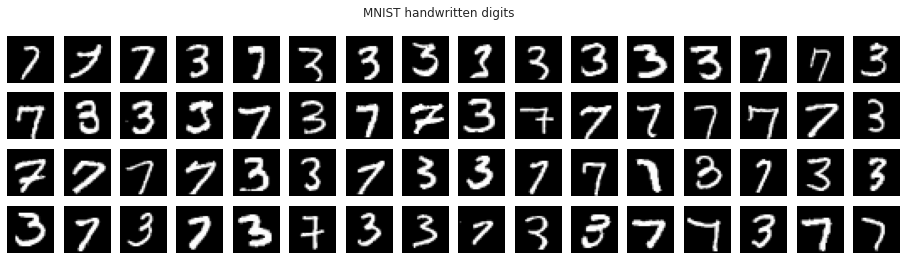

In [3]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

#### Building the VAE Model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [4]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 28**2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=128, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 2
num_samples = 10

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
)


#### Defining Loss and leverage PyTorch

In [5]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

#### Test Forward Pass

In [6]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)

if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)


torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 10, 2])
tensor(544.1130, device='cuda:0', grad_fn=<NegBackward>)
tensor(23.6604, device='cuda:0', grad_fn=<SumBackward0>)


#### Training

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


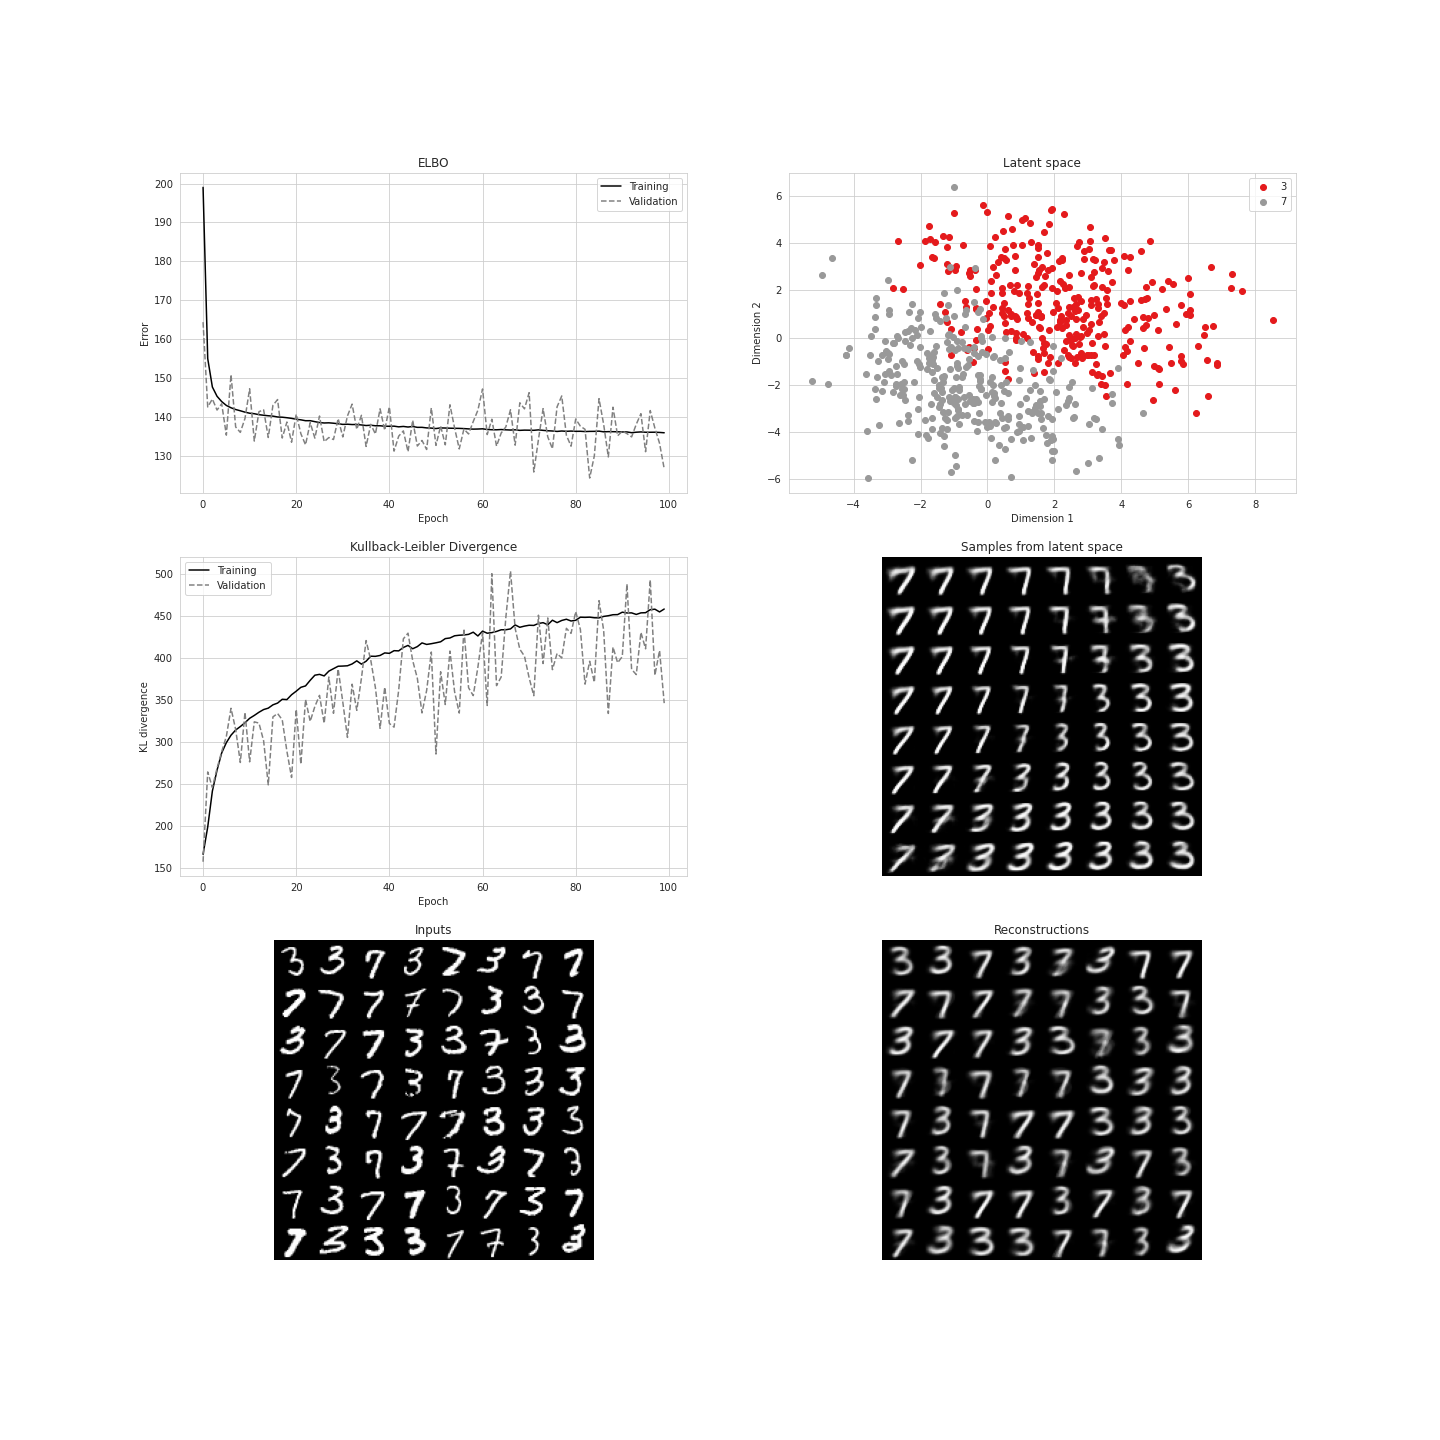

In [7]:
import os

num_epochs = 100
tmp_img = "tmp_vae_out.png"
show_sampling_points = False

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = Variable(x)
        
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    # -- Plotting --
    f, axarr = plt.subplots(3, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    rows = 8
    columns = batch_size // rows
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions
    # z = PCA(n=2).fit_transform(z)

    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.from_numpy(grid).float().to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = (samples[idx].cpu().numpy()).reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_hat[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)